# extractDirectionality

## Imports

In [1]:
import pandas as pd
import re 
import json
import datetime
import os
import time
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Subroutines
Subroutines neccessary for extractDirectionality
timeExtract takes the log file to be parsed, and returns the start time and end time in a tuple:<br>
    [startTime, endTime]<br>
<br>
durationinMicroseconds takes the log file to be parsed, and it returns the total duration, startTime, and endTime:<br>
    duration, startTime, endTime

In [3]:
# Extract time information of each recording from the log file
def timeExtract(filename):
    with open(filename, 'rb') as f:
        # Start counting from the last byte
        counter = 1
        # Go to the 2nd byte before the end of the last line
        f.seek(-2, 2) 
        while f.read(1) != b'\n':
            f.seek(-2, 1)
            counter=counter+1
        endTime_line = f.readline().decode()
        # Go to the 2nd byte before the end of the last second line
        f.seek(-counter-2, 2)
        while f.read(1) != b'\n':
            f.seek(-2, 1)
        startTime_line = f.readline().decode()

    return [startTime_line, endTime_line]

In [4]:
# Calculate duration of each recording in microseconds
def durationinMicroseconds(filename):
    startTime = timeExtract(filename)[0].split()[2:]
    endTime = timeExtract(filename)[1].split()[2:]
    startTimeStr = startTime[0] + ' ' + startTime[1]
    endTimeStr = endTime[0] + ' ' + endTime[1]
    T1 = datetime.datetime.strptime(startTimeStr, '%Y-%m-%d %H:%M:%S.%f')
    T2 = datetime.datetime.strptime(endTimeStr, '%Y-%m-%d %H:%M:%S.%f')
    delta = T2-T1
    duration = delta.seconds*1000000 + delta.microseconds
    
    return duration, T1, T2

## Function: extractDirectionalities
Decription:<br>
extractDirectionalities accepts a log file generated from data collected from an ODAS microphone, it will then organize the file into a dataframe, where each data point is time, direction, and strength of a single source.<br><br>
Parameters:<br>
**log file path, Microphopne Number**<br><br>
Returns a dataframe with the following columns:<br> 
**Timestamp, Time, Time In Seconds, Microphone Number, ID, X, Y, Z, Activity** <br>


In [5]:
def extractDirectionalities(filename, mic_number):
    with open(filename, 'r') as f:
        text = f.read()
        # Use repex to store blocks of data into a list
    data = re.split('(?<=})\n(?={)', text) 
        # Delete the time info from the last data block
    tmp = data[-1][:(data[-1].rfind("}")+1)]
    data[-1] = tmp
        
    #list of src blocks 
    srcList = [json.loads(block)["src"] for block in data]
    
    #initialize dataframe to have colums: timestamp, time, data inside source
    #timestamp is the initial time stamp
    #time is the datetime value converted from the timestamp and intitial time
    #source is a 4 by 6 array where the rows are the source, and the columns are the source values
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    
    #Used for calculating timestamps -> time
    duration, startTime, endTime = durationinMicroseconds(filename)
    start_time_in_seconds = time.mktime(startTime.timetuple())
    t = duration/len(data) / 1000000
    
    index = 1.0
    for block in srcList:
        if block[0]["id"] != 0 or block[1]["id"] != 0 or block[2]["id"] != 0 or block[3]["id"] != 0:
            time_in_seconds = start_time_in_seconds + (index - 1.0) * t
            for i in range(0, 4):
                if block[i]['id'] != 0:
                    df = df.append(pd.DataFrame({"Timestamp": [index], "Time":datetime.datetime.fromtimestamp(time_in_seconds).strftime("%A, %B %d, %Y %I:%M:%S"), "Time In Seconds": time_in_seconds, "Microphone Number":mic_number, "Source ID": block[i]["id"], "X": block[i]["x"], "Y": block[i]["y"], "Z": block[i]["z"], "Activity": block[i]["activity"]}, index=[0]))
        index = index + 1.0
            
    return(df)
            

## Function: mergeDirectionalities
Decription: <br>
mergeDirectionalities will iterate through all the files in "data" folder, and it will use extractDirectionalities create each file into a dataframe. The dataframe created will be appended into a master dataframe consiting of all the dataframes created from using extractDirectionalities on each file in "data" folder. <br>

Prerequirements:<br>
All folders in "data" folder must be filled with desired .log files in their respective recordingx folders.To do this, run the function above to automate it, or manually download the files from google drive and insert them into the correct folders.<br><br>

Parameters:<br>
None.<br><br>

Returns a dataframe with the following columns:<br> 
**Timestamp, Time, Time In Seconds, Microphone Number, ID, X, Y, Z, Activity** <br>

In [6]:
def mergeDirectionalities():   
    #create dataframe
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for i in range(4):
        for filename in glob.glob("/home/ardelalegre/CSE4223-ODAS/data/recordings" + str(i) + "/*.log"):
        #for filename in glob.glob("notast4ing"):
            with open(filename, 'r') as f:
                firstline = f.readline()
            if firstline == "SST log contains no useful data\n":
                pass
            else:
                df1 = extractDirectionalities(filename, i)
                df = df.append(df1)
            
    df = df.sort_values(['Time In Seconds'])
    return df

## Function: directionalitiesOfMicrophone

Description:<br>
directionalitiesOfMicrophone takes the directory of all the log files produced by a single microphone, and it will create a dataframe from that data.<br><br>
Parameters:<br>
String representation of the path from the home directory to the directory of the log files of the given microphone.<br><br>
Returns a dataframe with the following columns:<br> 
**Timestamp, Time, Time In Seconds, Microphone Number, ID, X, Y, Z, Activity** <br>

In [7]:
def diectionalitiesOfMicrophone(microphone_directory):
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for filename in glob.glob(microphone_directory +  "*.log"):
        with open(filename, 'r') as f:
            firstline = f.readline()
        if firstline == "SST log contains no useful data\n":
            pass
        else:
            df1 = extractDirectionalities(filename, i)
            df = df.append(df1)
    return df

# K Clustering

## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

In [9]:
data = extractDirectionalities("/Users/ardelalegre/CSE4223-ODAS/data/recordings0/cSSt_2019-09-09_14_55_03.log", 0)

X = data[['X', 'Y', 'Z']].values

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ardelalegre/CSE4223-ODAS/data/recordings0/cSSt_2019-09-09_14_55_03.log'

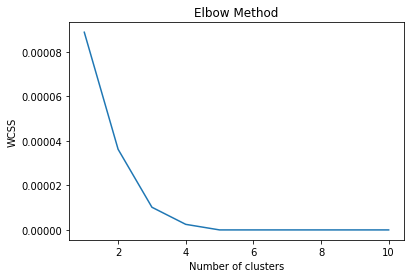

In [46]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

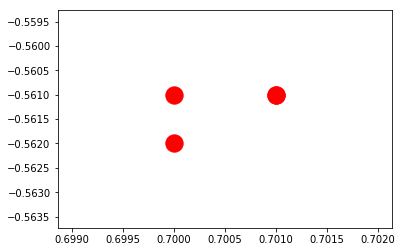

In [75]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1], X[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

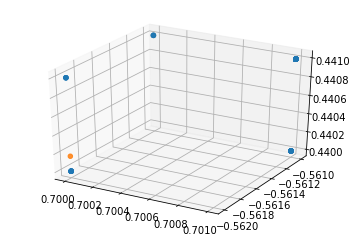

In [72]:
ax = plt.axes(projection='3d')
ax.scatter(data['X'].values,data['Y'].values, data['Z'])
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2])

In [74]:
print(kmeans.cluster_centers_[:, 1])

[-0.561 -0.562 -0.561 -0.561]


In [68]:
d = mergeDirectionalities()

NameError: name 'notast4ing' is not defined

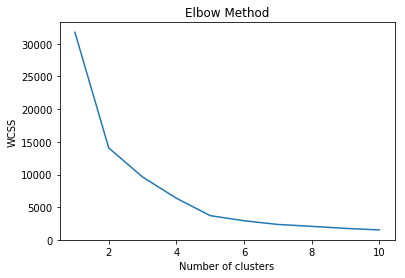

In [32]:
x = d[['X', 'Y', 'Z']].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

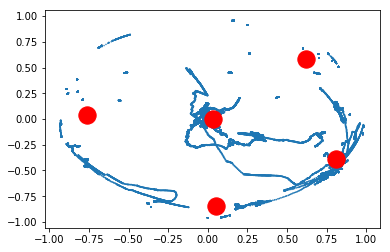

In [33]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
plt.scatter(x[:,0], x[:,1], x[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

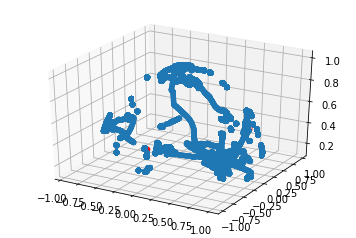

In [34]:
ax = plt.axes(projection='3d')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red')
ax.scatter(d['X'].values,d['Y'].values, d['Z'])

2020-01-08-09-25-03
## K means for January 8

In [34]:
def to_CSV(mic_number):
    dataframe = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for filename in glob.glob("/home/ardelalegre/google-drive/ODAS/recordings" + str(mic_number) + "/*.log"):
        if("2020-01-08" in filename):
            print(filename)
            try:
                dataframe = extractDirectionalities(filename, mic_number)
                dataframe.to_csv(path_or_buf='/home/ardelalegre/CSE4223-ODAS/data/recordings' + str(mic_number) + '/' + filename[48:filename.find('.log')] + '.csv')
            except:
                print("Error with file " + filename)
    return dataframe   

In [ ]:
zero = to_CSV(0)
#zero.head()

/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_15:15:03.log


/home/ardelalegre/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_17:00:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_21:55:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_02:05:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_02:05:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_03:35:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_03:35:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_10:25:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_23:45:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_18:15:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_01:45:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_01:45:03.log
/home/ardelalegre/google-drive/ODAS/recordings0/cSST_2020-01-08_21:35:03.log
/home/ardelalegre/google-dri

In [35]:
one = to_CSV(1)

/home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_09:50:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_09:50:03.log
/home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_09:55:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_09:55:03.log
/home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:00:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:00:03.log
/home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:05:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:05:03.log
/home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:10:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:10:03.log
/home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020-01-08_10:15:03.log
Error with file /home/ardelalegre/google-drive/ODAS/recordings1/cSST_2020

In [ ]:
two = micKCluster(2)

In [ ]:
three = micKCluster(3)

In [30]:
def csv_to_dataframe(mic_number):
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for filename in glob.glob("/home/ardelalegre/CSE4223-ODAS/data/recordings" + str(mic_number) + '/*.csv'):
        df = df.append(pd.read_csv(filename))
    return df

In [31]:
df = csv_to_dataframe(0)

In [16]:
df.tail

<bound method NDFrame.tail of       Activity Microphone Number Source ID  \
0        0.986                 0         2   
1        0.975                 0         2   
2        0.923                 0         2   
3        0.947                 0         2   
4        0.903                 0         2   
5        0.864                 0         2   
6        0.852                 0         2   
7        0.930                 0         2   
8        0.806                 0         2   
9        0.942                 0         2   
10       0.960                 0         2   
11       0.911                 0         2   
12       0.916                 0         2   
13       0.986                 0         2   
14       0.954                 0         2   
15       0.893                 0         2   
16       0.966                 0         2   
17       0.758                 0         2   
18       0.787                 0         2   
19       0.852                 0         2   
20  

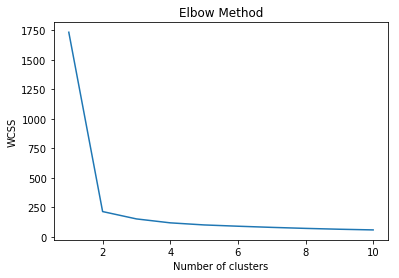

In [8]:
x = df[['X', 'Y', 'Z']].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


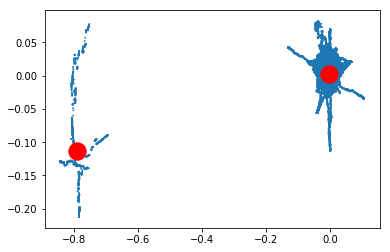

In [10]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
plt.scatter(x[:,0], x[:,1], x[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

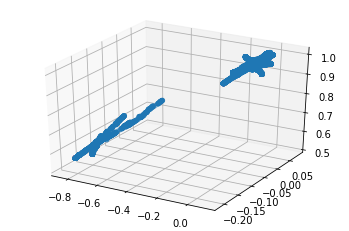

In [18]:
ax = plt.axes(projection='3d')
#ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red')
ax.scatter(df['X'].values,df['Y'].values, df['Z'].values)

In [17]:
x.shape

(1036973, 3)